In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# TensorFlow/Keras (Keras layers and optimizers below)
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

# sklearn
from sklearn.model_selection import KFold

# Custom
import sys
sys.path.insert(0, '../src/utils')
# from trace_handler import TraceHandler
from data_loader import DataLoader
import constants
# from single_byte_evaluator import SingleByteEvaluator
sys.path.insert(0, '../src/modeling')
from network import Network
from evaluator import Evaluator

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [3]:
BYTE_IDX = 0
# N_CLASSES = 256 ############# look at to_categorical of DataLoader if something goes wrong

train_dl = DataLoader('/prj/side_channel/PinataTraces/datasets/SBOX_OUT/D1-K1.json', BYTE_IDX)
x_train, y_train, _ = train_dl.gen_train() # Default 80% train (40,000 train traces)

Loading the dataset... 
Dataset successfully loaded (7.84 seconds).


In [4]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

HP_CHOICES = {#'kernel_initializer': ['random_normal', 'random_uniform', 
              #                       'truncated_normal', 
              #                       'zeros', 'ones', 
              #                       'glorot_normal', 'glorot_uniform',
              #                       'he_normal', 'he_uniform',
              #                       'identity', 'orthogonal', 'constant', 'variance_scaling'],
              'kernel_initializer': ['random_normal', 'random_uniform', 'truncated_normal', 'he_normal', 'he_uniform'],  
              'activation':         ['relu', 'tanh'],
              'hidden_layers':      [1, 2, 3, 4, 5, 6],
              'hidden_neurons':     [100, 200, 300, 400, 500, 600],
              'dropout_rate':       [0.0, 0.2, 0.4],
              'optimizer':          [SGD, Adam, RMSprop],
              'learning_rate':      [1e-3, 1e-4, 1e-5, 1e-6],
              'batch_size':         [50, 100, 200, 500, 1000]}

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = {'es': True,
             'reduceLR': True}

In [ ]:
N_MODELS = 10
N_EXP = 10
EPOCHS = 300

METRIC = 'ACC'

kf = KFold(n_splits=N_EXP)

hps = []
results = [] # list of tuples (model_id, model_avg_val_loss, model_history)
for i in range(N_MODELS):
    print(f'------------------------------ Model {i+1}/{N_MODELS} ------------------------------')
    
    random_hp = {k: random.choice(HP_CHOICES[k]) for k in HP_CHOICES}
    hps.append(random_hp)
    
    net = Network('MLP')
    net.set_hp(random_hp)

    net_metric = []
    for e, (train_indices, val_indices) in tqdm(enumerate(kf.split(x_train))):
        
        net.build_model()
        
        x_t = x_train[train_indices]
        y_t = y_train[train_indices]
        
        x_v = x_train[val_indices]
        y_v = y_train[val_indices]
        
        net.train_model(x_t,
                        y_t,
                        epochs=EPOCHS,
                        verbose=0,
                        cb=callbacks,
                        validate=True,
                        x_val=x_v,
                        y_val=y_v)
        
        val_loss, val_acc = net.evaluate_model(x_v, y_v)
        
        net.reset_model()
        
        if METRIC == 'LOSS':
            metric = val_loss
        else:
            metric = val_acc
            
        net_metric.append(metric)
    
    net_metric = np.array(net_metric)
    net_avg_metric = np.mean(net_metric)
    
    results.append((i, net_avg_metric))
    
    print(f'Avg {METRIC}: {net_avg_metric}')
    print()

Finished.


4it [00:58, 15.17s/it]

Training...
Finished.


5it [01:15, 16.14s/it]

Training...
Finished.


6it [01:36, 17.79s/it]

Training...
Finished.


7it [01:50, 16.43s/it]

Training...
Finished.


8it [02:07, 16.44s/it]

Training...
Finished.


9it [02:20, 15.61s/it]

Training...
Finished.


10it [02:36, 15.66s/it]


Avg ACC: 0.004025000007823109

------------------------------ Model 4/10 ------------------------------


0it [00:00, ?it/s]

Training...
Finished.


1it [00:39, 39.37s/it]

Training...
Finished.


2it [01:26, 44.18s/it]

Training...
Finished.


3it [01:31, 25.89s/it]

Training...
Finished.


4it [02:12, 32.18s/it]

Training...
Finished.


5it [02:17, 22.17s/it]

Training...


In [ ]:
rev = True

if METRIC == 'LOSS':
    rev = False
    
results.sort(key=lambda x: x[1], reverse=rev)
print()
print(f'K-Fold Crossvalidation Results: {[(idx, metric) for idx, metric in results]}')

In [ ]:
best_hp = hps[results[0][0]]
best_hp

In [ ]:
from evaluator import Evaluator

ges_single = []
ges_diff = []

for i, device in enumerate(constants.DEVICES):
    for j, key in enumerate(constants.KEYS):
        
        print(f'----- {device}-{key} -----')
        
        if device == 'D1' and key == 'K1':
            path = '/prj/side_channel/PinataTraces/datasets/SBOX_OUT/D1-K1.json'
        else:
            path = f'/prj/side_channel/PinataTraces/datasets/SBOX_OUT/{device}-{key}.json'

        test_dl = DataLoader(path, BYTE_IDX)
        x_test, y_test, pltxt_test = test_dl.gen_test()
        true_key_byte = test_dl.get_true_key_byte()
        
        evaluator = Evaluator(x_test, pltxt_test, true_key_byte, 'MLP')

        ge_single_model = evaluator.guessing_entropy(n_exp=10,
                                                     hp=best_hp,
                                                     x_train=x_train,
                                                     y_train=y_train,
                                                     epochs=200,
                                                     single_model=True)
        ges_single.append(ge_single_model)
        
        print()
        
#         ge_diff_models = evaluator.guessing_entropy(n_exp=10,
#                                                     hp=best_hp,
#                                                     x_train=x_train,
#                                                     y_train=y_train,
#                                                     epochs=200,
#                                                     single_model=False)
        
#         ges_diff.append(ge_diff_models)
        
#         print()

ges_single = np.array(ges_single)
# ges_diff = np.array(ges_diff)

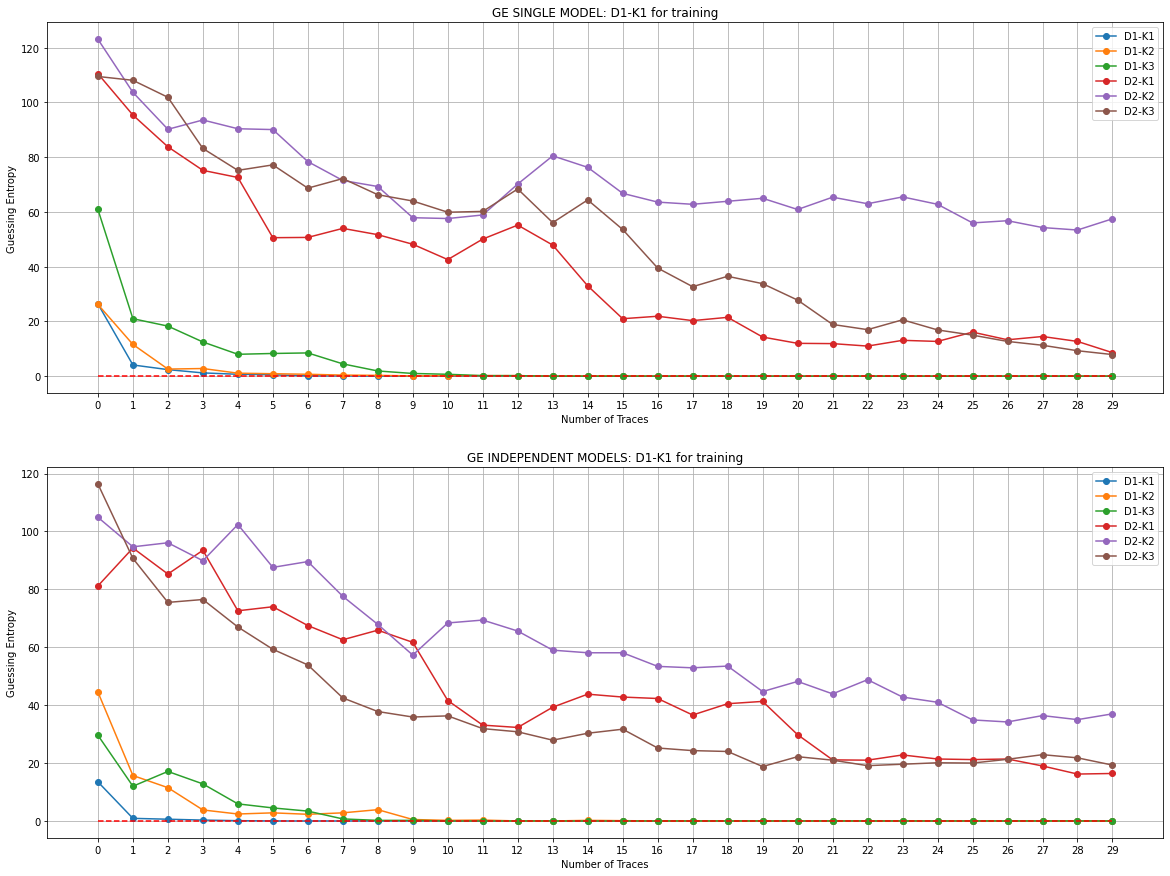

In [46]:
N = 30

f, ax = plt.subplots(2, 1, figsize=(20,15))

device = 1
for i in range(len(ges_single)):
    
    key = i % 3
    
    ax[0].plot(ges_single[i][:N], marker='o', label=f'D{device}-K{key+1}')
    ax[1].plot(ges_diff[i][:N], marker='o', label=f'D{device}-K{key+1}')
    
    if key == 2:
        device += 1

ax[0].plot(np.zeros(N), color='r', ls='--')
ax[0].set_title('GE SINGLE MODEL: D1-K1 for training')
ax[0].set_xlabel('Number of Traces')
ax[0].set_ylabel('Guessing Entropy')
ax[0].set_xticks(range(N))
ax[0].grid()
ax[0].legend()

ax[1].plot(np.zeros(N), color='r', ls='--')
ax[1].set_title('GE INDEPENDENT MODELS: D1-K1 for training')
ax[1].set_xlabel('Number of Traces')
ax[1].set_ylabel('Guessing Entropy')
ax[1].set_xticks(range(N))
ax[1].grid()
ax[1].legend()

plt.show()

In [29]:
ges_single.shape

(6, 10000)

10000

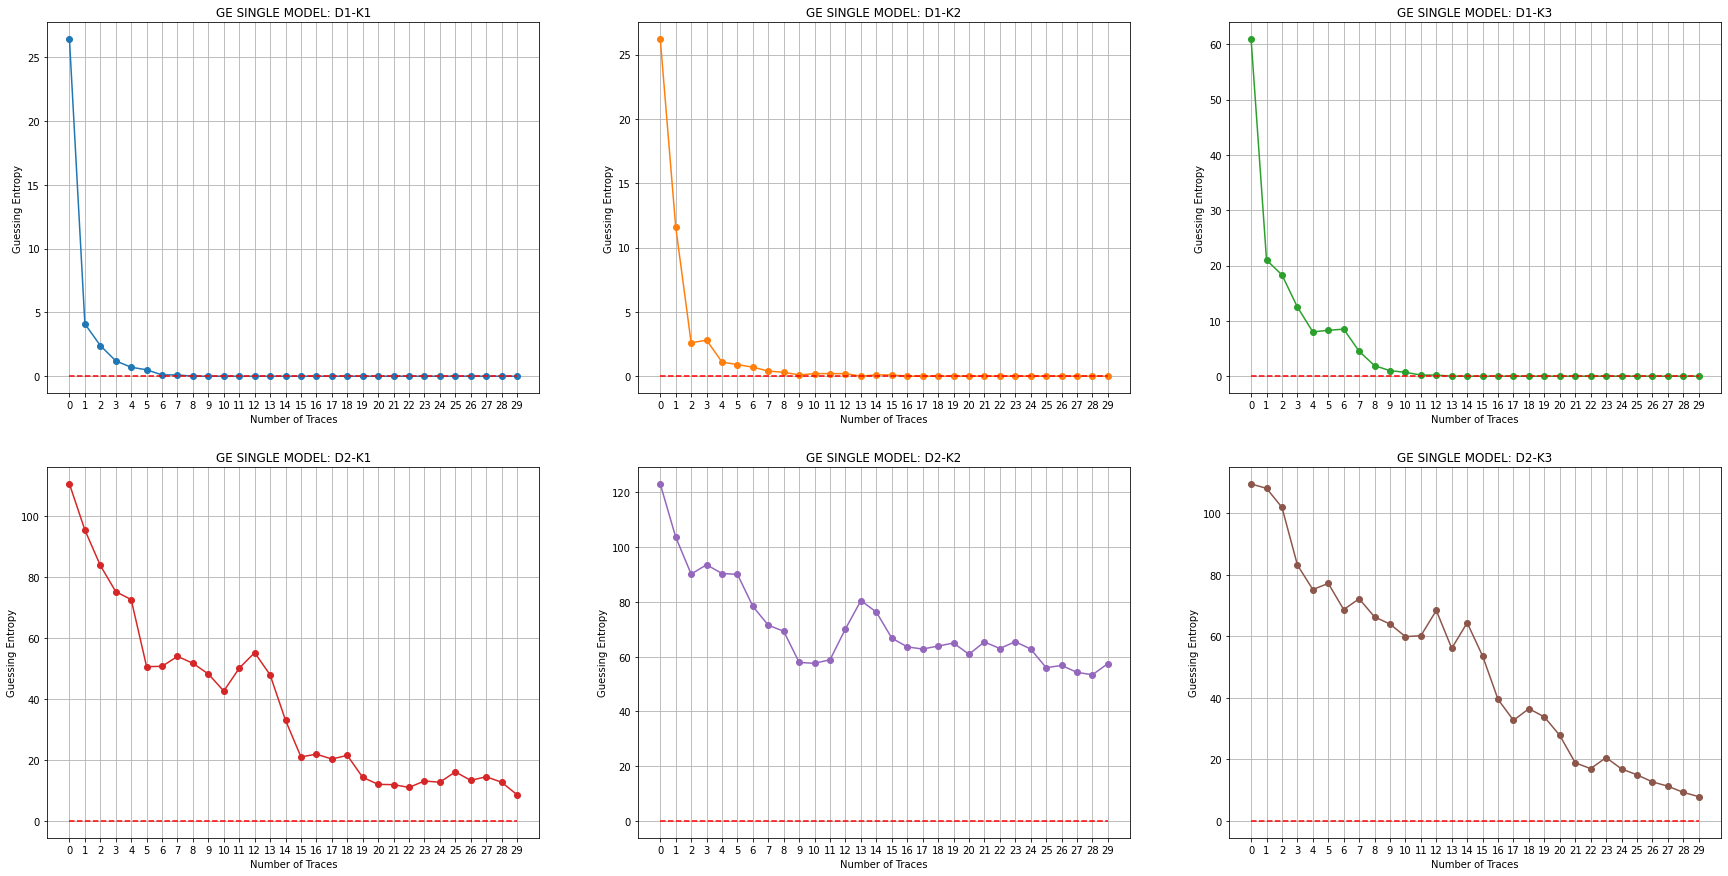

In [55]:
import matplotlib.colors as colors

N = 30

f, ax = plt.subplots(len(constants.DEVICES), len(constants.KEYS), figsize=(30,15))

row = 0
for i in range(len(ges_single)):
    
    col = i % 3
    
    ax[row, col].plot(ges_single[i][:N], marker='o', color=list(colors.TABLEAU_COLORS.keys())[i])
    ax[row, col].plot(np.zeros(N), color='r', ls='--')
    ax[row, col].set_title(f'GE SINGLE MODEL: D{row+1}-K{col+1}')
    ax[row, col].set_xlabel('Number of Traces')
    ax[row, col].set_ylabel('Guessing Entropy')
    ax[row, col].grid()
    ax[row, col].set_xticks(range(N))
    
    if col == 2:
        row += 1

plt.show()

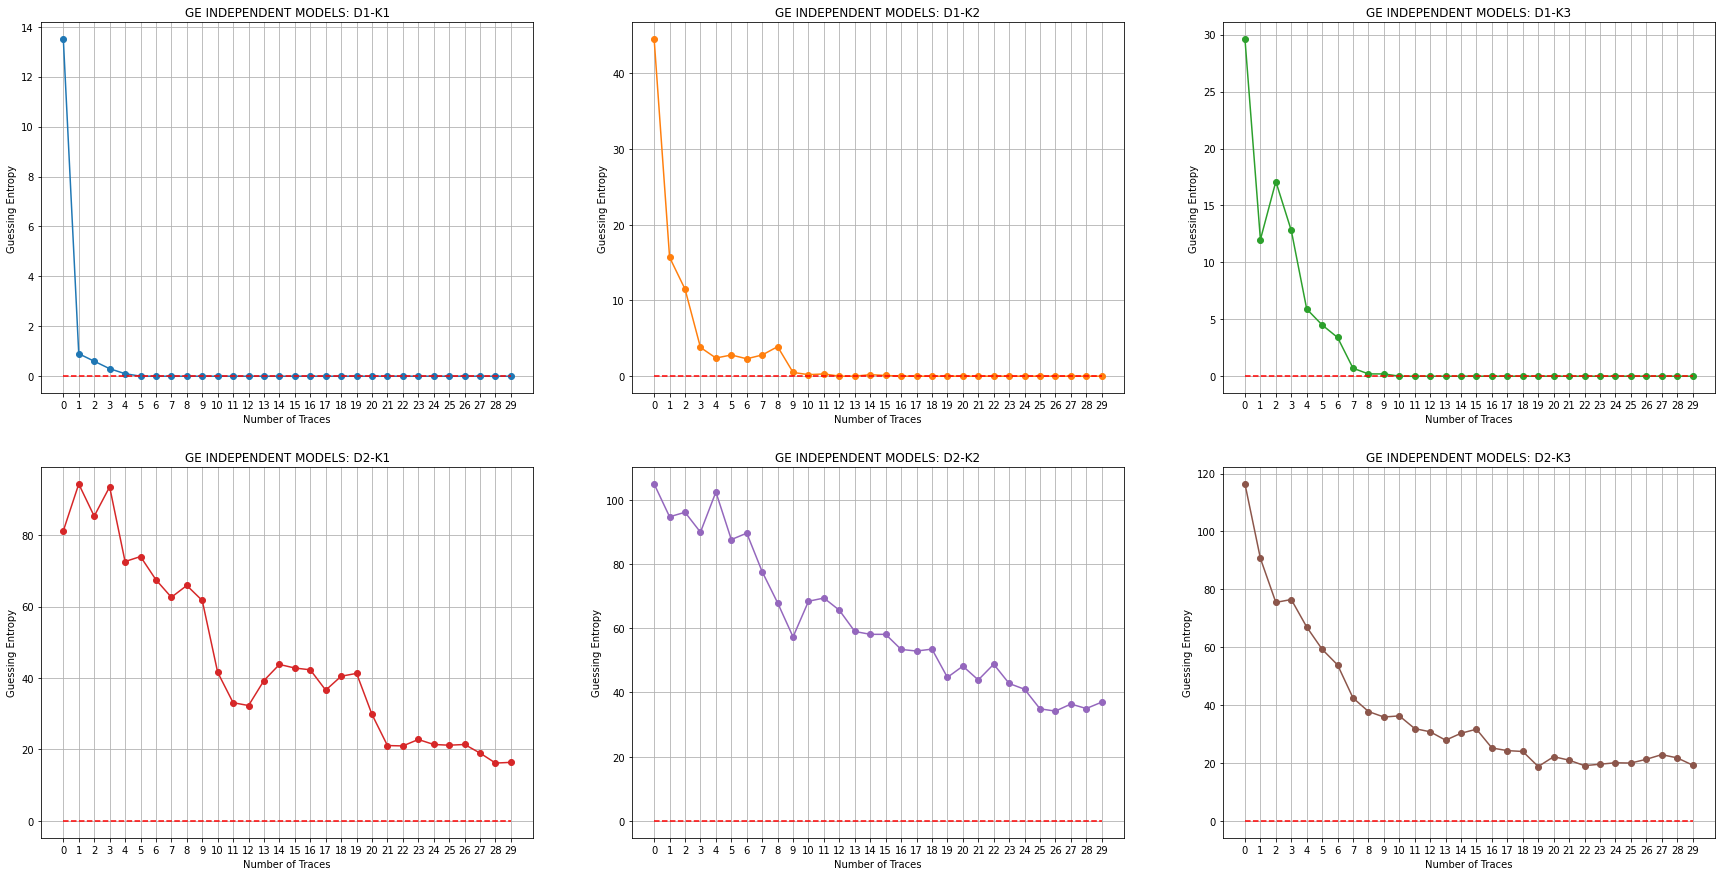

In [56]:
import matplotlib.colors as colors

N = 30

f, ax = plt.subplots(len(constants.DEVICES), len(constants.KEYS), figsize=(30,15))

row = 0
for i in range(len(ges_diff)):
    
    col = i % 3
    
    ax[row, col].plot(ges_diff[i][:N], marker='o', color=list(colors.TABLEAU_COLORS.keys())[i])
    ax[row, col].plot(np.zeros(N), color='r', ls='--')
    ax[row, col].set_title(f'GE INDEPENDENT MODELS: D{row+1}-K{col+1}')
    ax[row, col].set_xlabel('Number of Traces')
    ax[row, col].set_ylabel('Guessing Entropy')
    ax[row, col].grid()
    ax[row, col].set_xticks(range(N))
    
    if col == 2:
        row += 1

plt.show()

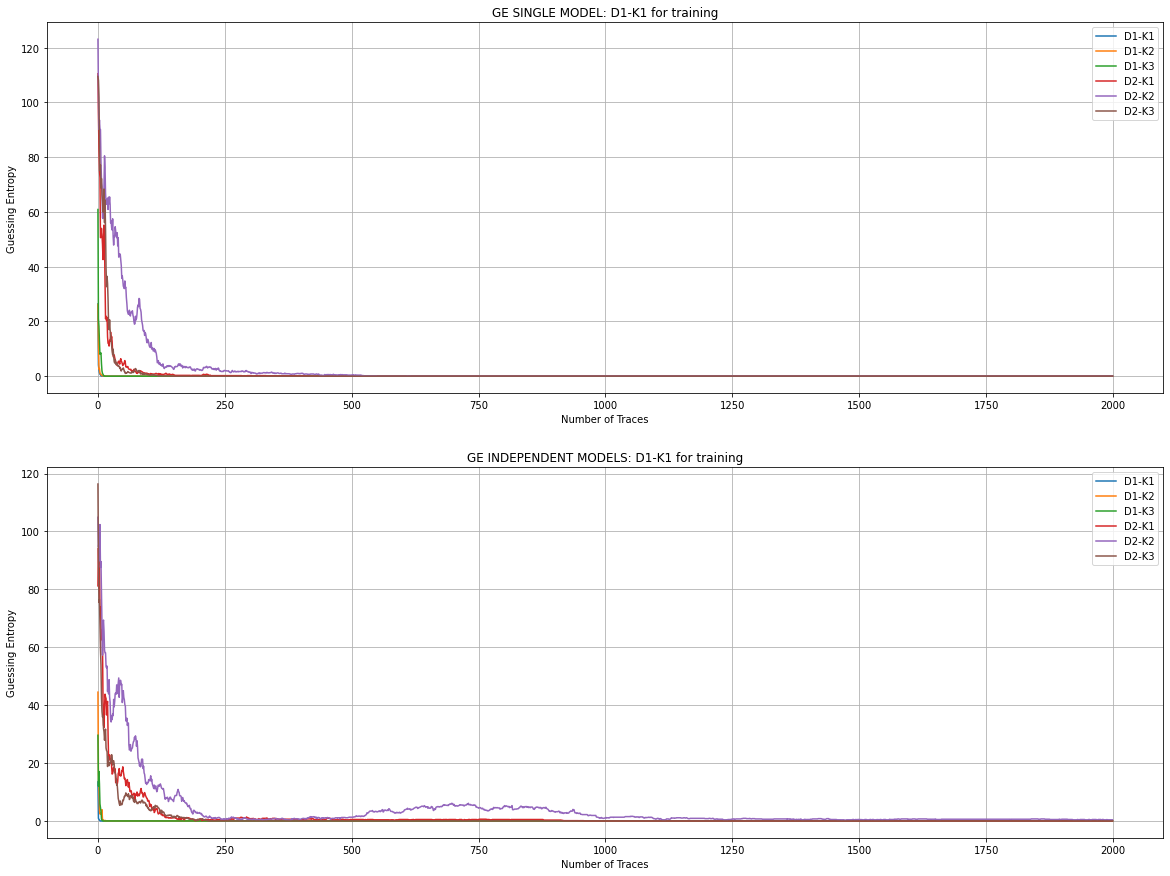

In [61]:
f, ax = plt.subplots(2, 1, figsize=(20,15))

device = 1
for i in range(len(ges_single)):
    
    key = i % 3
    
    ax[0].plot(ges_single[i][:2000], label=f'D{device}-K{key+1}')
    ax[1].plot(ges_diff[i][:2000], label=f'D{device}-K{key+1}')
    
    if key == 2:
        device += 1

ax[0].set_title('GE SINGLE MODEL: D1-K1 for training')
ax[0].set_xlabel('Number of Traces')
ax[0].set_ylabel('Guessing Entropy')
ax[0].grid()
ax[0].legend()

ax[1].set_title('GE INDEPENDENT MODELS: D1-K1 for training')
ax[1].set_xlabel('Number of Traces')
ax[1].set_ylabel('Guessing Entropy')
ax[1].grid()
ax[1].legend()

plt.show()